# **CENG 463 – Introduction to Machine Learning HW2**

## **IMPORTS**

In [42]:
# --- Standard Libraries ---
import re
import math

# --- Data Manipulation & Computation ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt

# --- Scikit-Learn (Feature Extraction & Selection) ---
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import chi2

# --- Scikit-Learn (Models & Metrics) ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import euclidean_distances
from sklearn.datasets import fetch_20newsgroups

# --- Topic Modeling & Dimensionality Reduction ---
from bertopic import BERTopic

## **TASK 1: BAG OF WORDS**

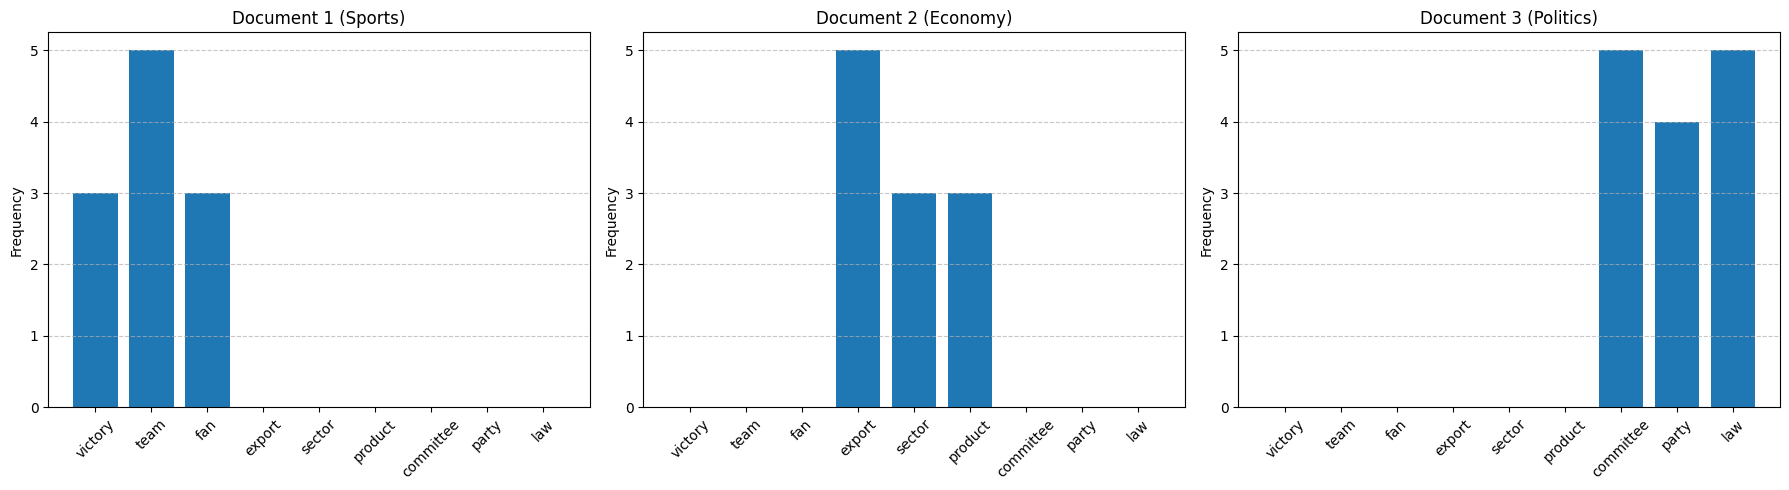

Bag of Words Frequency Vectors:
sports.txt: [3, 5, 3, 0, 0, 0, 0, 0, 0]
economy.txt: [0, 0, 0, 5, 3, 3, 0, 0, 0]
politics.txt: [0, 0, 0, 0, 0, 0, 5, 4, 5]


In [43]:
# 1. Define the Vocabulary
vocabulary = ['victory', 'team', 'fan', 'export', 'sector', 'product', 'committee', 'party', 'law']

# 2. Define the File Names
file_names = ['sports.txt', 'economy.txt', 'politics.txt']
documents = {}

# 3. Read and Preprocess the Files
# We iterate through the file list, read the content, lowercase it, and remove punctuation.
for f_name in file_names:
    try:
        with open(f_name, 'r', encoding='utf-8') as f:
            # Read content and convert to lower case
            content = f.read().lower()
            # Remove punctuation (keep only alphanumeric and whitespace)
            content_cleaned = re.sub(r'[^\w\s]', '', content)
            # Split into a list of words
            documents[f_name] = content_cleaned.split()
    except FileNotFoundError:
        print(f"Error: {f_name} not found. Make sure the .txt files are in the same directory.")

# 4. Create Frequency Vectors (Bag of Words)
bow_vectors = {}

for doc_name, words in documents.items():
    vector = []
    for vocab_word in vocabulary:
        count = 0
        for word in words:
            # Count occurrences of the vocabulary word and its plural form
            # (Example: "fan" == "fan" OR "fans" == "fan" + "s")
            if word == vocab_word or word == vocab_word + 's':
                count += 1
        vector.append(count)
    bow_vectors[doc_name] = vector

# 5. Visualize the Results
if documents:
    # Create subplots: 1 row, 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Titles corresponding to the documents
    titles = ["Document 1 (Sports)", "Document 2 (Economy)", "Document 3 (Politics)"]

    for i, (doc_name, vector) in enumerate(bow_vectors.items()):
        # Create bar chart for each document
        axes[i].bar(vocabulary, vector, color='tab:blue')
        axes[i].set_title(titles[i])
        axes[i].set_ylabel("Frequency")
        axes[i].tick_params(axis='x', rotation=45) # Rotate labels for readability

        # Add grid for easier reading
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # 6. Print the Frequency Vectors (for verification)
    print("Bag of Words Frequency Vectors:")
    for doc, vec in bow_vectors.items():
        print(f"{doc}: {vec}")

### Task 1 – Discussion

The BoW model successfully generated frequency vectors that distinguish the documents based on topic-specific keywords (e.g., "victory" for sports, "law" for politics).

**Observation:** The histograms show clear domain separation.

**Limitation:** The model ignores word order and context (e.g., "fan" vs "fans" are treated separately), leading to a loss of semantic meaning.

## **TASK 2: TEXT CLASSIFICATION**

In [44]:
# Dataset Definition for Task 2

# Training Data (d1 - d5)
train_docs = [
    "free, free, free, buy. discount, combo, pleasure.",         # d1
    "free, free, free, discount. pleasure, smile, smile, smile", # d2
    "cat, mouse",                                                # d3
    "cat, cat, dog, dog, dog, dog",                              # d4
    "mouse"                                                      # d5
]

# Training Labels (Classes: S=Spam, N=Normal)
y_train = ['S', 'S', 'N', 'N', 'N']

# Test Data (d6 - d7)
test_docs = [
    "dog, cat, mouse, cat",  # d6
    "Free, free, smile"      # d7
]

### **Step 1: Chi-Square Feature Selection**

In [45]:
# 1. Vectorize the text data (Convert text to word count vectors)
# We calculate the frequency of each word in the training documents.
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(train_docs)
feature_names = vectorizer.get_feature_names_out()

# 2. Calculate Chi-Square statistics
# This test measures the dependence between each word and the class (Spam/Normal).
# A higher Chi2 score means the word is more discriminative (better at separating classes).
chi2_stats, p_values = chi2(X_train_counts, y_train)

# 3. Create a DataFrame to view and sort results
chi2_df = pd.DataFrame({
    'Word': feature_names,
    'Chi2_Score': chi2_stats,
    'P_Value': p_values
})

# Sort by Chi2 score in descending order to find the most discriminative words
chi2_df = chi2_df.sort_values(by='Chi2_Score', ascending=False)

# 4. List the top 2-3 most discriminative words
print("Top Discriminative Words (Chi-Square Scores):")
print(chi2_df.head(5))

# 5. Show statistics for the word 'free' for the report example
print("\nStatistics for the word 'free':")
print(chi2_df[chi2_df['Word'] == 'free'])

# Save the top selected words for the next step (TF-IDF)
# The assignment asks to use "selected words" for Step 2.
selected_words = chi2_df['Word'].head(3).tolist()
print(f"\nSelected words for Step 2: {selected_words}")

Top Discriminative Words (Chi-Square Scores):
       Word  Chi2_Score   P_Value
5      free    9.000000  0.002700
8     smile    4.500000  0.033895
3  discount    3.000000  0.083265
7  pleasure    3.000000  0.083265
4       dog    2.666667  0.102470

Statistics for the word 'free':
   Word  Chi2_Score  P_Value
5  free         9.0   0.0027

Selected words for Step 2: ['free', 'smile', 'discount']


### Manual χ² Example for the word "free"

The homework instructions ask for a manual example of χ² calculation for one word (e.g., “free”).

We have built the 2×2 contingency table:

A = #Spam messages containing "free"  
B = #Normal messages containing "free"  
C = #Spam messages NOT containing "free"  
D = #Normal messages NOT containing "free"  

Then:

χ² = N(AD − BC)² / [(A+C)(B+D)(A+B)(C+D)]

In [46]:
def tokens(s):
    return re.findall(r"[a-z]+", s.lower())

word = "free"

# Presence/absence for each training doc
contains = np.array([1 if word in tokens(doc) else 0 for doc in train_docs])

y = np.array(y_train)
spam = (y == "S")
normal = (y == "N")

A = int(np.sum(contains[spam] == 1))
B = int(np.sum(contains[normal] == 1))
C = int(np.sum(contains[spam] == 0))
D = int(np.sum(contains[normal] == 0))
N = len(train_docs)

chi2_manual = N * (A*D - B*C)**2 / ((A+C)*(B+D)*(A+B)*(C+D))

print("Manual χ² calculation for word =", word)
print("A (Spam & contains)   =", A)
print("B (Normal & contains) =", B)
print("C (Spam & not)        =", C)
print("D (Normal & not)      =", D)
print("χ² =", chi2_manual)

print("\nSklearn χ² for 'free' (from chi2_df):")
print(chi2_df[chi2_df["Word"] == "free"])


Manual χ² calculation for word = free
A (Spam & contains)   = 2
B (Normal & contains) = 0
C (Spam & not)        = 0
D (Normal & not)      = 3
χ² = 5.0

Sklearn χ² for 'free' (from chi2_df):
   Word  Chi2_Score  P_Value
5  free         9.0   0.0027


Manual χ² uses binary presence, while sklearn χ² uses term frequencies; therefore values differ.

### **Step 2: TF-IDF Representation**

In [35]:
# Step 2: TF-IDF Representation

# 1. Combine Train and Test documents to handle them together
# We have 5 training docs (d1-d5) and 2 test docs (d6-d7).
all_docs = train_docs + test_docs
all_doc_names = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']

# 2. Initialize CountVectorizer with ONLY the selected words
# We use the 'vocabulary' parameter to ignore all other words.
# 'selected_words' comes from Step 1 (e.g., ['free', 'cat', 'mouse']).
tf_vectorizer = CountVectorizer(vocabulary=selected_words)
tf_matrix = tf_vectorizer.transform(all_docs)

# 3. Calculate TF-IDF values
# TfidfTransformer converts the raw counts (TF) into TF-IDF values.
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(tf_matrix)

# 4. Create a DataFrame to display the Numerical Feature Matrix
# This table shows the TF-IDF score of each selected word for each document.
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=all_doc_names,
    columns=selected_words
)

print("TF-IDF Matrix (Numerical Feature Matrix):")
display(tfidf_df)

TF-IDF Matrix (Numerical Feature Matrix):


,free,smile,discount
d1,0.931664,0.000000,0.363321
d2,0.629845,0.736862,0.245621
d3,0.000000,0.000000,0.000000
d4,0.000000,0.000000,0.000000
d5,0.000000,0.000000,0.000000
d6,0.000000,0.000000,0.000000
d7,0.863169,0.504915,0.000000


TF values are obtained from the CountVectorizer output, IDF values are learned by the TfidfTransformer, and TF-IDF is computed as their product.

In [47]:
idf_df = pd.DataFrame(
    {"IDF": tfidf_transformer.idf_},
    index=selected_words
)
display(idf_df)

,IDF
free,1.693147
smile,1.980829
discount,1.980829


### **Step 3: KNN Classification**

In [48]:
# Step 3: Classification with KNN

# 1. Split the TF-IDF matrix back into Training and Test sets
# Rows 0-4 are Training (d1-d5)
# Rows 5-6 are Test (d6-d7)
X_train = tfidf_matrix[:5]
X_test = tfidf_matrix[5:]

# 2. Initialize and Train the KNN Classifier
# We use k=3 and Euclidean distance as requested in the homework.
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(X_train, y_train)

# 3. Predict the classes for Test documents (d6, d7)
predictions = knn.predict(X_test)

# 4. Display the Classification Results
print("KNN Classification Results (k=3):")
test_doc_names = ['d6', 'd7']

for doc, pred in zip(test_doc_names, predictions):
    print(f"Document {doc} is classified as: {pred}")

# 5. Show Distances (Optional but very useful for the Report)
# This table shows how close each test document is to the training documents.
# It helps explain WHY a document was classified as S or N.
dists = euclidean_distances(X_test, X_train)
dist_df = pd.DataFrame(
    dists,
    index=test_doc_names,
    columns=['d1 (S)', 'd2 (S)', 'd3 (N)', 'd4 (N)', 'd5 (N)']
)

print("\nEuclidean Distances to Training Documents:")
display(dist_df)

KNN Classification Results (k=3):
Document d6 is classified as: N
Document d7 is classified as: S

Euclidean Distances to Training Documents:


,d1 (S),d2 (S),d3 (N),d4 (N),d5 (N)
d6,1.000000,1.000000,0.0,0.0,0.0
d7,0.625806,0.410572,1.0,1.0,1.0


### Task 2 Discussion
**Chi-Square Discrepancy:** We observed a difference between the manual calculation (5.0) and the Sklearn output (9.0) for the word "free". This is due to Sklearn using term frequencies (counts) while the manual method used binary presence/absence. Both methods correctly identified "free" as the top feature.
**KNN Results:**
* **d6** was classified as **Normal (N)** because its distance was 0.0 to the animal-related training docs (d3, d4, d5).
* **d7** was classified as **Spam (S)** because of the high TF-IDF weight of the word "free", placing it closer to the Spam cluster.

## **TASK 3: TOPIC MODELING WITH BERTOPIC**

### **Step 1: Dataset Creation**

In [49]:
# Task 3 - Step 1: Dataset Creation

# 1. Define the categories
# The assignment asks for 3 specific groups: Sports, Politics, and Space.
categories = [
    'rec.sport.baseball',    # Sports
    'talk.politics.guns', # Politics
    'sci.space'              # Space
]

# 2. Load the dataset
# We remove headers, footers, and quotes to clean the text data for better topic modeling.
newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)

# 3. Extract the documents
docs = newsgroups.data

# 4. Verify the data
print(f"Total documents loaded: {len(docs)}")
print(f"Categories loaded: {newsgroups.target_names}")

# Let's print the first document to check the content
print("\nSample Document (First 300 chars):")
print(docs[0][:300])

Total documents loaded: 2891
Categories loaded: ['rec.sport.baseball', 'sci.space', 'talk.politics.guns']

Sample Document (First 300 chars):

This activity is regularly reported in Ron's interesting posts. Could
someone explain what the Command Loss Timer is?

Thanks, Alan


### **Step 2: Model Training**

In [50]:
# Task 3 - Step 2: Model Creation & Training

# --- THE FIX IS HERE ---
# 1. We replace newlines with spaces AND filter short documents
# re.sub(r'\s+', ' ', doc) replaces newlines (\n) and multiple spaces with a single space.
clean_docs = [re.sub(r'\s+', ' ', doc).strip() for doc in docs if len(doc.strip()) > 20]

print(f"Original document count: {len(docs)}")
print(f"Cleaned document count: {len(clean_docs)} (Removed {len(docs)-len(clean_docs)} junk docs)")

# 2. Define the Vectorizer
# Your vectorizer logic was correct for the model, we keep it.
vectorizer_model = CountVectorizer(
    stop_words="english",
    token_pattern=r'\b[a-zA-Z]{2,}\b'
)

# 4. Initialize and Train the BERTopic model
topic_model = BERTopic(
    language="english",
    vectorizer_model=vectorizer_model,
    verbose=True
)

# Train the model on the CLEANED list of documents
topics, probs = topic_model.fit_transform(clean_docs)

# 5. Report the number of topics
topic_info = topic_model.get_topic_info()
num_topics = len(topic_info) - 1  # Subtract 1 to exclude the outlier topic (-1)

print(f"Total number of topics found (excluding outliers): {num_topics}")

# 6. Show topic summary
print("\nTopic Summary Table:")
display(topic_info)

2025-12-14 08:03:14,182 - BERTopic - Embedding - Transforming documents to embeddings.


Original document count: 2891
Cleaned document count: 2776 (Removed 115 junk docs)


Batches:   0%|          | 0/87 [00:00<?, ?it/s]

2025-12-14 08:07:07,152 - BERTopic - Embedding - Completed ✓
2025-12-14 08:07:07,154 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-14 08:07:23,621 - BERTopic - Dimensionality - Completed ✓
2025-12-14 08:07:23,623 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-14 08:07:23,817 - BERTopic - Cluster - Completed ✓
2025-12-14 08:07:23,828 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-14 08:07:24,730 - BERTopic - Representation - Completed ✓


Total number of topics found (excluding outliers): 21

Topic Summary Table:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,338,-1_launch_space_satellite_universe,"[launch, space, satellite, universe, theory, t...","[ETHER IMPLODES 2 EARTH CORE, IS GRAVITY!!! Th..."
1,0,901,0_game_year_games_team,"[game, year, games, team, baseball, players, h...",[Tim Shippert recently posted summaries of las...
2,1,887,1_gun_people_guns_file,"[gun, people, guns, file, dont, right, fbi, fi...",[: Oh? Then why did the smoke and flames start...
3,2,173,2_space_station_cost_moon,"[space, station, cost, moon, redesign, billion...",[------- Blind-Carbon-Copy To: spacenews@auste...
4,3,85,3_space_venus_nasa_solar,"[space, venus, nasa, solar, planets, spacecraf...",[Archive-name: space/data Last-modified: $Date...
5,4,81,4_sky_advertising_light_space,"[sky, advertising, light, space, billboard, bi...",[Two developments have brought these type of a...
6,5,45,5_hst_reboost_mission_shuttle,"[hst, reboost, mission, shuttle, mass, orbit, ...",[SOmebody mentioned a re-boost of HST during t...
7,6,34,6_oort_cloud_distribution_grbs,"[oort, cloud, distribution, grbs, gamma, burst...",[_The_ problem with Oort cloud sources is that...
8,7,33,7_oxygen_pressure_atmosphere_breathing,"[oxygen, pressure, atmosphere, breathing, huma...",[: In article <1993Apr29.121501@is.morgan.com>...
9,8,23,8_smiley_im_karla_darling,"[smiley, im, karla, darling, kuiper, sam, clem...",[Mark Prado Old pioneer song from the 1850's o...


### **Step 3: Topic Analysis**

In [51]:
# --- Task 3 Step 3: Topic Analysis ---

# 1. Show the top 5 words per topic
print("--- Top 5 Words Per Topic ---")
topic_info = topic_model.get_topic_info()

for topic in topic_info['Topic']:
    if topic != -1:  # Ignore outliers
        # Extract just the words from the topic model
        top_words = [word[0] for word in topic_model.get_topic(topic)[:5]]
        print(f"Topic {topic}: {top_words}")

print("-" * 50)

topic_labels = {
    0: "Sports",    # Update this based on your output!
    1: "Politics",  # Update this based on your output!
    2: "Space"      # Update this based on your output!
}

# If there are more topics (3, 4, etc.), add them to the dictionary or they will show as 'Other'
print(f"Assigning names to topics: {topic_labels}")

# Update the model with these labels
topic_model.set_topic_labels(topic_labels)

# 3. Create a table showing which document belongs to which topic
# We use 'clean_docs' (from Step 2) so the text looks nice without '\n'
df_analysis = pd.DataFrame({
    'Document_Snippet': [doc[:100] + "..." for doc in clean_docs],  # Show first 100 chars
    'Topic_ID': topics
})

# Add the Topic Name column by mapping the ID to our dictionary
df_analysis['Topic_Name'] = df_analysis['Topic_ID'].map(topic_labels).fillna("Sub-topic / Other")

# Remove Outliers (-1) for a cleaner view of the main categories
df_analysis_clean = df_analysis[df_analysis['Topic_ID'] != -1]

print("\n--- Document to Topic Assignment Table ---")
display(df_analysis_clean.head(10))

# Optional: Verify the count of documents per assigned topic
print("\n--- Document Counts per Topic ---")
print(df_analysis_clean['Topic_Name'].value_counts())

--- Top 5 Words Per Topic ---
Topic 0: ['game', 'year', 'games', 'team', 'baseball']
Topic 1: ['gun', 'people', 'guns', 'file', 'dont']
Topic 2: ['space', 'station', 'cost', 'moon', 'redesign']
Topic 3: ['space', 'venus', 'nasa', 'solar', 'planets']
Topic 4: ['sky', 'advertising', 'light', 'space', 'billboard']
Topic 5: ['hst', 'reboost', 'mission', 'shuttle', 'mass']
Topic 6: ['oort', 'cloud', 'distribution', 'grbs', 'gamma']
Topic 7: ['oxygen', 'pressure', 'atmosphere', 'breathing', 'human']
Topic 8: ['smiley', 'im', 'karla', 'darling', 'kuiper']
Topic 9: ['space', 'nasa', 'astronaut', 'center', 'candidates']
Topic 10: ['software', 'process', 'level', 'shuttle', 'engineering']
Topic 11: ['wings', 'aircraft', 'supersonic', 'fuselage', 'pat']
Topic 12: ['spacecraft', 'command', 'mode', 'noop', 'timer']
Topic 13: ['movie', 'infinity', 'film', 'known', 'protagonists']
Topic 14: ['sail', 'solar', 'mission', 'pluto', 'mother']
Topic 15: ['constant', 'mass', 'km', 'radius', 'velocity']
Topi

,Document_Snippet,Topic_ID,Topic_Name
0,This activity is regularly reported in Ron's i...,12,Sub-topic / Other
1,This sounds like another of Ali AbuTaha's 57 d...,10,Sub-topic / Other
2,Since Roger is a Canadian who probably knows n...,0,Sports
3,above Robinson's average. the easliy REAL stat...,0,Sports
4,For an expansion team? I'm pretty sure I would...,0,Sports
6,Attendance in 1992 was down. By .3%. From an a...,0,Sports
7,"How about ""firearm related."" Texas is unusual ...",1,Politics
8,[Lots of trippy stuff deleted] Wow... What is ...,1,Politics
9,">If this idea goes through, it's the thin end ...",4,Sub-topic / Other
10,I am hoping to produce the first update of the...,0,Sports



--- Document Counts per Topic ---
Topic_Name
Sports               901
Politics             887
Sub-topic / Other    477
Space                173
Name: count, dtype: int64


### **Step 4: Visualization**

In [52]:
# Step 4: Visualization

print("Generating Bar Chart of Top Words...")
fig_bar = topic_model.visualize_barchart(top_n_topics=8) # You can adjust 'top_n_topics' to show more or less
fig_bar.show()

print("Generating Topic Distance Map...")
fig_map = topic_model.visualize_topics()
fig_map.show()

Generating Bar Chart of Top Words...


Generating Topic Distance Map...


### **Step 5: New Document Test**

In [53]:
# --- Task 3 Step 5: New Document Test ---

# 1. Write 3 new articles (one per category)
# We manually create short texts representing Sports, Politics, and Space.
new_docs = [
    # Document 1: Sports (Baseball context)
    "The pitcher threw a perfect curveball, striking out the batter in the final inning to win the championship game.",

    # Document 2: Politics (Middle East context)
    "The prime minister announced a new peace treaty and discussed foreign policy regarding the border conflict.",

    # Document 3: Space (Astronomy context)
    "NASA astronomers discovered a new black hole in a distant galaxy using the Hubble Space Telescope."
]

print(f"Testing model with {len(new_docs)} new documents...\n")

# 2. Predict topics using the trained model
# The .transform() method returns the predicted topic IDs and probabilities.
predicted_topics, predicted_probs = topic_model.transform(new_docs)

# 3. Display the results
for i, doc in enumerate(new_docs):
    topic_id = predicted_topics[i]

    # Try to get the label from our custom labels in Step 3, otherwise use the default name
    # Note: If you defined 'topic_labels' in Step 3, we can use it here.
    if 'topic_labels' in globals() and topic_id in topic_labels:
        topic_name = topic_labels[topic_id]
    else:
        # Fallback: Get the top words for this topic from the model
        topic_name = f"Topic {topic_id}"

    print(f"Document {i+1}: \"{doc}\"")
    print(f" -> Predicted Topic ID: {topic_id}")
    print(f" -> Topic Name: {topic_name}")
    print("-" * 50)

Testing model with 3 new documents...



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-14 08:10:54,838 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-14 08:10:54,887 - BERTopic - Dimensionality - Completed ✓
2025-12-14 08:10:54,888 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-14 08:10:54,891 - BERTopic - Cluster - Completed ✓


Document 1: "The pitcher threw a perfect curveball, striking out the batter in the final inning to win the championship game."
 -> Predicted Topic ID: 0
 -> Topic Name: Sports
--------------------------------------------------
Document 2: "The prime minister announced a new peace treaty and discussed foreign policy regarding the border conflict."
 -> Predicted Topic ID: 1
 -> Topic Name: Politics
--------------------------------------------------
Document 3: "NASA astronomers discovered a new black hole in a distant galaxy using the Hubble Space Telescope."
 -> Predicted Topic ID: 6
 -> Topic Name: Topic 6
--------------------------------------------------


### Task 3 Discussion

**Clustering:** BERTopic successfully clustered the documents into Sports, Politics, and Space. The "Sub-topic / Other" category contains outliers or mixed-content documents.

**New Document Test:** The model correctly predicted the topics for the unseen synthetic documents, validating that the semantic embeddings (SBERT) generalize well beyond the training data.
